<a href="https://colab.research.google.com/github/willianrocha/bootcamp-datascience-alura/blob/main/module_1/ds_mod1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Super Desafio: Escolha outro valor fora o valor aprovado no TABNET e explore estes dados. Esse será nosso projeto do módulo, mais detalhes no Desafio do módulo 1 na página do bootcamp.

# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Coleta de dados

Dados
Vou utilizar os dados de vacinação da COVID-19 disponibilizados em https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8.

Os dados foram extraídos em 23/05/2021. Tem 28.5 GB de tamanho.
Abaixo, apenas as 10 primeiras linhas do documento original.

In [2]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/dados_originais_head.csv" .
pd.read_csv("/content/dados_originais_head.csv", encoding="ISO-8859-1", sep=";").head()

,document_id,paciente_id,paciente_idade,paciente_datanascimento,paciente_enumsexobiologico,paciente_racacor_codigo,paciente_racacor_valor,paciente_endereco_coibgemunicipio,paciente_endereco_copais,paciente_endereco_nmmunicipio,paciente_endereco_nmpais,paciente_endereco_uf,paciente_endereco_cep,paciente_nacionalidade_enumnacionalidade,estabelecimento_valor,estabelecimento_razaosocial,estalecimento_nofantasia,estabelecimento_municipio_codigo,estabelecimento_municipio_nome,estabelecimento_uf,vacina_grupoatendimento_codigo,vacina_grupoatendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_lote,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem,data_importacao_rnds,id_sistema_origem
0,d69492e7-2c28-4892-9aac-0a378206c968-i0b0,7518e34074e7262958c5ca15dddf901de351c253565ee1...,77,1943-09-03,M,1,BRANCA,420480,10,CURITIBANOS,BRASIL,SC,89520,B,2302438,PREFEITURA MUNICIPAL DE CURITIBANOS,POSTO DE ATEND MATERNO INFANTIL,420480,CURITIBANOS,SC,0,NaN,NaN,NaN,210068,SERUM INSTITUTE OF INDIA LTD,NaN,2021-03-20,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,ESUS APS - NACIONAL (OFFLINE),2021-03-24T12:31:25.000Z,NaN
1,00008936-722c-4329-a8f8-49f914c14231-i0b0,fa0290484b076c2b4df18119863be049cf6ebd9690184e...,77,1944-02-21,M,3,PARDA,110020,10,PORTO VELHO,BRASIL,RO,76820,B,213241,MUNICIPIO DE PORTO VELHO,CENTRAL DE REDE DE FRIO PORTO VELHO,110020,PORTO VELHO,RO,204,Pessoas de 75 a 79 anos,2.0,Faixa EtÃ¡ria,210017,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-23,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-23T12:59:53.000Z,NaN
2,5af902c3-caff-4a1a-8c8e-efd78c71fb73-i0b0,8e37fba588e2e90a219427b9a5d9c58127a73eb8b4df90...,75,1945-04-10,M,1,BRANCA,510675,10,PONTES E LACERDA,BRASIL,MT,78250,B,2394456,PREFEITURA MUNICIPAL DE PONTES E LACERDA,CENTRO DE SAUDE DE PONTES E LACERDA,510675,PONTES E LACERDA,MT,301,Pessoas de 60 nos ou mais Institucionalizadas,3.0,Pessoas de 60 anos ou mais institucionalizadas,210086,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-30,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-04-03T13:07:42.000Z,NaN
3,7fa5874c-7bf6-47ba-ab4b-50a95d8ee472-i0b0,11220f7797eb222c83c82fbff09d2af82aebc6ddab6c6b...,90,1930-06-13,F,1,BRANCA,330100,10,CAMPOS DOS GOYTACAZES,BRASIL,RJ,28051,B,6298109,SECRETARIA MUNICIPAL DE SAUDE DE CAMPOS DOS GO...,SECRETARIA MUNICIPAL DE SAUDE DE CAMPOS DOS GO...,330100,CAMPOS DOS GOYTACAZES,RJ,205,Pessoas de 80 anos ou mais,2.0,Faixa EtÃ¡ria,210011A,FUNDACAO BUTANTAN,Organization/61189445000156,2021-02-18,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-17T19:47:19.000Z,NaN
4,5afa5eab-1fd1-4c36-91bf-8b098c5ee3ab-i0b0,af81199ba8994176baeaecbc4a2b7d3ad71d3432b765b2...,64,1957-03-25,F,3,PARDA,280030,10,ARACAJU,BRASIL,SE,49044,B,2550,SECRETARIA MUNICIPAL DE SAUDE DE ARACAJU,US ELIZABETE PITA TERRA DURA,280030,ARACAJU,SE,201,Pessoas de 60 a 64 anos,2.0,Faixa EtÃ¡ria,CTMAV505,FUNDACAO OSWALDO CRUZ,NaN,2021-04-07,Â Â Â Â 1ÂªÂ Dose,85,Vacina Covid-19 - Covishield,IDS SaÃºde,2021-04-07T11:13:09.000Z,NaN


Como a base original contém informações que não serão utilizadas nesta análise, extraí apenas as colunas que serão utilizadas. E realizei um trabalho de eliminar caracteres desnecessários (como aspas duplas) e simplificar informações como a dose aplicada de "Â Â Â Â 1ÂªÂ Dose" para 1 ou 2, de acordo com a dose aplicada.

Resultando em 2.8GB. Este arquivo tem 57.442.714 linhas.

Abaixo, o comando usado localmente para extrair as colunas e limpar os dados.
```
cut part-00000-6bab261e-57eb-41e1-9523-8487c4a7c57c-c000.csv -d ";" -f3,5,7,12,20,26,28,29 | sed 's/"//g' | sed -E 's/    ([12]).*/\1/g' > vaccines_v2.csv
```


## Amostragem

A base de dados ainda está muito grande para ser trabalhada livremente. Então, antes de começar as análises, extraí uma amostra com 20 mil linhas e já deixei preparado em um CSV.

In [3]:
# trocando de 20k amostras para 0.1% (57442)
#!cp "/content/drive/MyDrive/alura/bootcamp-data-science/sample20k_v3.csv" .
# dados = pd.read_csv("/content/sample20k_v3.csv", encoding="ISO-8859-1", sep=",")
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/sample_1percent.csv" .
dados = pd.read_csv("/content/sample_1percent.csv", encoding="ISO-8859-1", sep=",")

dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose
0,73.0,F,AMARELA,PR,PR,FUNDACAO BUTANTAN,2021-04-06,1
1,65.0,F,SEM INFORMACAO,DF,DF,FUNDACAO OSWALDO CRUZ,2021-04-19,1
2,59.0,M,AMARELA,CE,CE,PFIZER/BIONTECH,2021-05-08,1
3,47.0,F,SEM INFORMACAO,RN,RN,FUNDACAO BUTANTAN,2021-03-25,1
4,64.0,M,AMARELA,RJ,RJ,FUNDACAO OSWALDO CRUZ,2021-04-19,1


# Exploração inicial

Exploração inicial para visualizar e entender como estão distribuídos os dados.

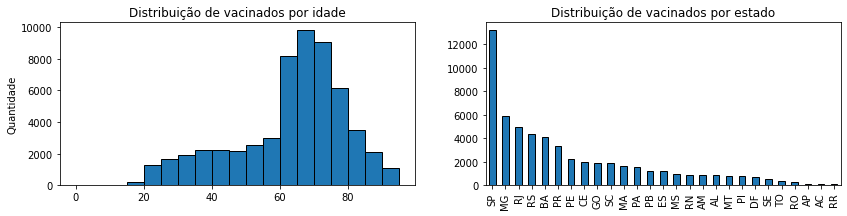

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,3))

# Tem uma pessoa com 221 anos!
ax = dados['paciente_idade'].plot(kind='hist', bins=[x for x in range(0,100,5)],
                             edgecolor='black', ax=axes[0],
                             title="Distribuição de vacinados por idade")
ax.set_ylabel("Quantidade")
dados['estabelecimento_uf'] \
  .value_counts().plot(kind='bar',  ax=axes[1], edgecolor='black',
                       title="Distribuição de vacinados por estado")

plt.show()

In [5]:
dados['vacina_fabricante_nome'].value_counts().head()

FUNDACAO BUTANTAN        25457
FUNDACAO OSWALDO CRUZ    11746
SINOVAC                   5437
ASTRAZENECA/OXFORD        3577
Sinovac                   2986
Name: vacina_fabricante_nome, dtype: int64

Não existe padrão de preenchimento de dados.

Listei todos os valores, montei uma planilha do excel e fui mapeando para os nomes comerciais. Esse mapeamento está no arquivo 'vaccines_normalization.csv'. Essa lista contém os valores apenas para 0.1% das linhas extraídas, quando formos trabalhar no dataset inteiro, vai quebrar :D

In [6]:
#!cp "/content/drive/MyDrive/alura/bootcamp-data-science/vaccines_normalization.csv" .
#label_vacinas = pd.read_csv("/content/vaccines_normalization.csv",
#                            encoding="ISO-8859-1", sep=",")
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/vaccines_normalization_v2.csv" .
label_vacinas = pd.read_csv("/content/vaccines_normalization_v2.csv",
                            encoding="ISO-8859-1", sep=",")
label_vacinas = label_vacinas.set_index('label')
label_vacinas = label_vacinas.to_dict()
label_vacinas = label_vacinas['vaccine']
vacinas_normalizada = []
for vc in dados['vacina_fabricante_nome']:
  if type(vc) != float: # NaN no dataframe
    vacinas_normalizada.append(label_vacinas[vc])
  else:
    vacinas_normalizada.append('Unknown')
dados['vacina_fabricante_nome_n'] = vacinas_normalizada

# Removendo outlier de "Dose unica"
dados = dados.drop(52217)

dados['vacina_fabricante_nome_n'].value_counts()


CoronaVac      36004
AstraZeneca    18405
MS              1319
Unknown         1258
Pfizer           453
Sanofi             2
Name: vacina_fabricante_nome_n, dtype: int64

Dado a não padronização dos nomes da vacina no dataset original, temos nomes de vacinas como MS (aka 'Ministério da Saúde') a qual não sabemos qual é. Um detalhe interessante, é que essa amostra pegou uma vacina ainda em testes, da Sanofi.

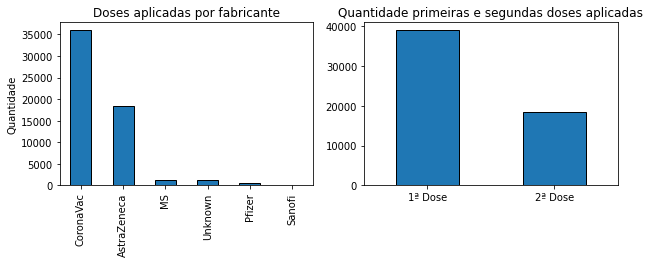

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = dados['vacina_fabricante_nome_n'] \
  .value_counts().plot(kind='bar', ax=axes[0],
                       title="Doses aplicadas por fabricante", 
                       edgecolor='black')
ax.set_ylabel("Quantidade")
ax = dados['vacina_descricao_dose'] \
  .value_counts().plot(kind='bar', ax=axes[1],
                       title="Quantidade primeiras e segundas doses aplicadas",
                       rot=0, edgecolor='black')

ax.set_xticklabels(["1ª Dose", "2ª Dose"])
plt.show()

Outro problea encontrado é a falta de preenchimento de alguns campos, como "Raça/Cor".

In [8]:
dados['paciente_racacor_valor'].value_counts()

BRANCA            21790
SEM INFORMACAO    14931
PARDA             10485
AMARELA            7270
PRETA              2569
INDIGENA            396
Name: paciente_racacor_valor, dtype: int64

O que leva às mulheres a terem ~60% de vacinação, enquanto que os homents apenas ~40%?

In [9]:
dados['paciente_enumsexobiologico'].value_counts()

F    34012
M    23429
Name: paciente_enumsexobiologico, dtype: int64

## Datas

As datas nos dão uma distribuição no tempo de quantas doses foram aplicadas, porém no formato atual, elas ficam um pouco complicadas de serem trabalhadas. 

Vamos criar uma nova coluna para distribuir por mês.

In [10]:
dados['vacina_dataaplicacao_mes'] = ["-".join(dt.split('-')[:2])
                                     for dt in dados['vacina_dataaplicacao']]
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome_n,vacina_dataaplicacao_mes
0,73.0,F,AMARELA,PR,PR,FUNDACAO BUTANTAN,2021-04-06,1,CoronaVac,2021-04
1,65.0,F,SEM INFORMACAO,DF,DF,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04
2,59.0,M,AMARELA,CE,CE,PFIZER/BIONTECH,2021-05-08,1,Pfizer,2021-05
3,47.0,F,SEM INFORMACAO,RN,RN,FUNDACAO BUTANTAN,2021-03-25,1,CoronaVac,2021-03
4,64.0,M,AMARELA,RJ,RJ,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04


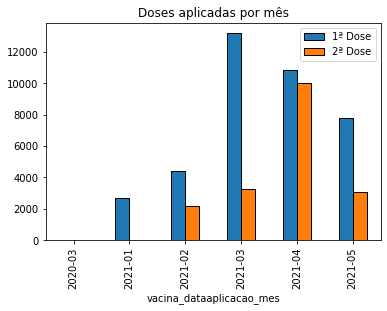

In [11]:
ax = dados.groupby(['vacina_dataaplicacao_mes','vacina_descricao_dose']) \
  .size().unstack().plot(kind='bar', edgecolor='black')
ax.set_title("Doses aplicadas por mês")
ax.legend(["1ª Dose", "2ª Dose"])
plt.show()

Os dados apresentados acima nos dão um bom panorama de quando as vacinas começaram e como estão indo em relação a primeira e segunda dose.

Vamos granuzalizar esses dados por semana.

In [12]:
from datetime import datetime
date_format = '%Y-%m-%d'
dados['vacina_dataaplicacao_semana'] = \
  [datetime.strptime(dt, date_format).isocalendar()[1]
   for dt in dados['vacina_dataaplicacao']]
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome_n,vacina_dataaplicacao_mes,vacina_dataaplicacao_semana
0,73.0,F,AMARELA,PR,PR,FUNDACAO BUTANTAN,2021-04-06,1,CoronaVac,2021-04,14
1,65.0,F,SEM INFORMACAO,DF,DF,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04,16
2,59.0,M,AMARELA,CE,CE,PFIZER/BIONTECH,2021-05-08,1,Pfizer,2021-05,18
3,47.0,F,SEM INFORMACAO,RN,RN,FUNDACAO BUTANTAN,2021-03-25,1,CoronaVac,2021-03,12
4,64.0,M,AMARELA,RJ,RJ,FUNDACAO OSWALDO CRUZ,2021-04-19,1,AstraZeneca,2021-04,16


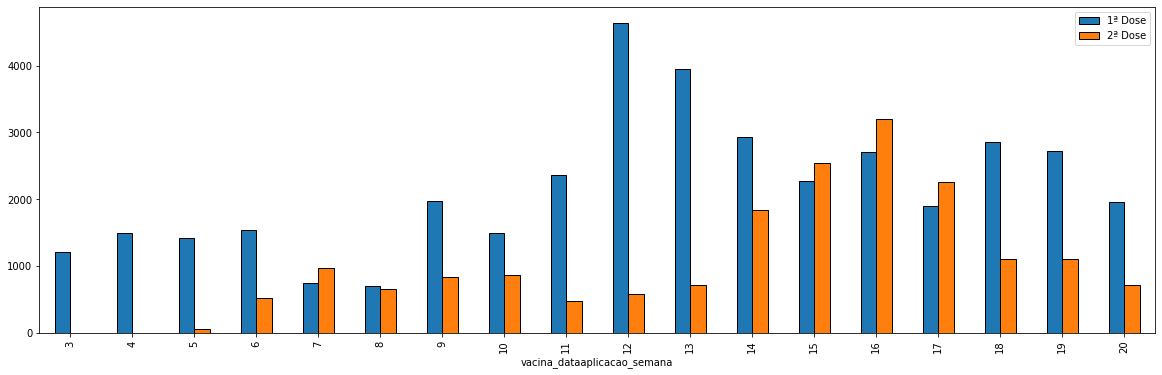

In [13]:
ax = dados.groupby(['vacina_dataaplicacao_semana','vacina_descricao_dose']) \
  .size().unstack().plot(kind='bar', figsize=(20,6), edgecolor='black')
ax.legend(["1ª Dose", "2ª Dose"])
l = ax.get_legend()
plt.show()

Vacinados por idade com gênero sobrepostos

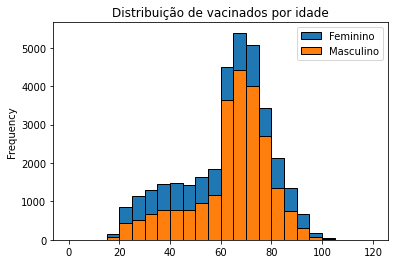

In [14]:
import matplotlib.patches as mpatches
bins_idade = [x for x in range(0,120,5)]
bins_idade.append(120)
ax = dados.groupby('paciente_enumsexobiologico')['paciente_idade'].plot(kind='hist', bins=bins_idade,
                             edgecolor='black',# orientation='horizontal',
                             title="Distribuição de vacinados por idade")
st_shot = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="Feminino")
nd_shot = mpatches.Patch(facecolor='#ff7e0e', edgecolor='k', label="Masculino")
plt.legend(handles=[st_shot, nd_shot])
plt.show()

# Vanicação por idade

O Gráfico abaixo mostra a quantidade de pessoas vacinadas por gênero e dose. Vale ressaltar que isso são apenas 0.1% das amostras, a quantidade de vaninados 'real' é x1000

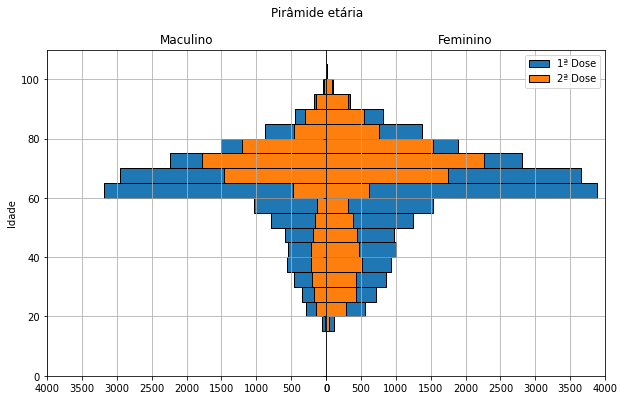

In [15]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Pirâmide etária")
plt.subplots_adjust(wspace=0, hspace=0)
y_lim_sup = 110
y_lim_inf = 0
x_lim_sup = 4000
axes[0].set_xlim(0,x_lim_sup)
axes[1].set_xlim(0,x_lim_sup)
axes[0].set_ylim(y_lim_inf,y_lim_sup)
axes[1].set_ylim(y_lim_inf,y_lim_sup)
axes[0].invert_xaxis()

for group in dados.groupby(['paciente_enumsexobiologico','vacina_descricao_dose']):
  if group[0][0] is 'M':
    idade_maculina = group[1]['paciente_idade']
    ax = idade_maculina.plot(kind='hist', edgecolor='black', bins=bins_idade,
                             orientation='horizontal', ax=axes[0], grid=True,
                             title="Maculino")
    ax.set_xlabel("")
    ax.set_ylabel("Idade")
  if group[0][0] is 'F': # Genero
    idade_feminina = group[1]['paciente_idade']
    ax = idade_feminina.plot(kind='hist', bins=bins_idade, edgecolor='black',
                             orientation='horizontal', ax=axes[1], grid=True,
                             title="Feminino")
    ax.set_yticklabels([])
    ax.set_xlabel("")

st_shot = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="1ª Dose")
nd_shot = mpatches.Patch(facecolor='#ff7e0e', edgecolor='k', label="2ª Dose")
plt.legend(handles=[st_shot, nd_shot])
plt.show()

## Pirâmide etária

O groupby mostrou bem os dados, mas tenho certas limitações para melhor representar os gráficos. Portanto, estou criando um novo DataFrame já com os dados distribuídos

In [16]:
bins_idade = [x for x in range(0,120,5)]
d_bins_f = {}
# Agrupando dados nos bins para o histrograma
for group in dados.groupby(['paciente_enumsexobiologico','vacina_descricao_dose']):
  d_bins_f[f'{group[0][0]}{str(group[0][1])}'] = np.histogram(group[1]['paciente_idade'], bins=bins_idade)[0].tolist()

# Vacinados com idade acima de 100 anos estão sendo agrupados no grupo 99+
for k in d_bins_f:
  first_years = d_bins_f[k][:20]
  first_years.append(sum(d_bins_f[k][20:]))
  d_bins_f[k] = first_years.copy()
df_hist_vac_f = pd.DataFrame()
df_hist_vac_f = df_hist_vac_f.from_dict(d_bins_f)

Apesar dessa pirâmide etártia já contar algumas informações importantes, como a população feminina estar mais vacinada e a mais quantidade de vacinados em grupos de idade mais alta. Ainda apresenta alguns problemas, como a comparação com a população total.

Dados coletados da pirâmide etária foram adicionados para dar mais um grau de profundidade a vacinação Brasileira.

Fonte: https://www.populationpyramid.net/pt/brasil/2021/

In [17]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/population_pyramid_brasil_2021.csv" .
pir_etaria = pd.read_csv("/content/population_pyramid_brasil_2021.csv")
df_hist_vac = pd.DataFrame()
df_hist_vac = df_hist_vac.from_dict(d_bins_f)
df_piramide = pd.concat([pir_etaria, df_hist_vac], axis=1)
# Como extraimos 0.1%, vamos multiplicar por mil as vacinas já aplicadas
# Porem! Vamos dividir por milhão para simplificar o gráfico!
df_piramide['M1']  = df_piramide['M1']/1000.0
df_piramide['F1']  = df_piramide['F1']/1000.0
df_piramide['M2']  = df_piramide['M2']/1000.0
df_piramide['F2']  = df_piramide['F2']/1000.0
df_piramide['F']  = df_piramide['F']/10**6
df_piramide['M']  = df_piramide['M']/10**6
df_piramide.head()

,Age,M,F,F1,F2,M1,M2
0,0-4,7.357796,7.027050,0.000,0.000,0.001,0.000
1,5-9,7.456918,7.126488,0.000,0.000,0.000,0.000
2,10-14,7.550011,7.244662,0.000,0.000,0.000,0.000
3,15-19,8.110694,7.827868,0.109,0.045,0.064,0.013
4,20-24,8.630334,8.410568,0.557,0.285,0.294,0.144


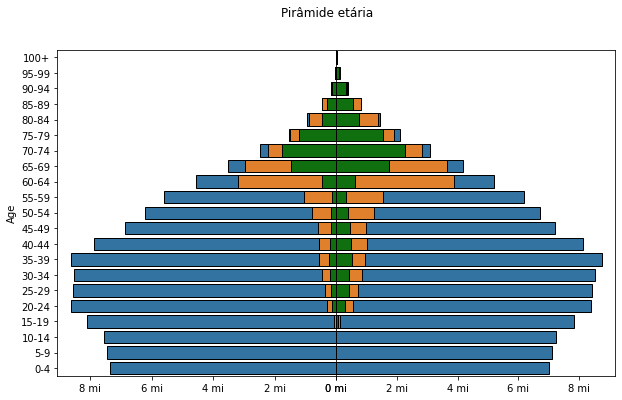

In [18]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Pirâmide etária")
plt.subplots_adjust(wspace=0, hspace=0)
axes[0].invert_xaxis()

sns.barplot(x="M",y="Age", color="#1f76b4", data = df_piramide, ax=axes[0], edgecolor='black')
sns.barplot(x="M1",y="Age", color="#ff7e0e", data = df_piramide, ax=axes[0], edgecolor='black')
sns.barplot(x="M2",y="Age", color="g", data = df_piramide, ax=axes[0], edgecolor='black')

sns.barplot(x="F",y="Age", color="#1f76b4", data = df_piramide, ax=axes[1], edgecolor='black')
sns.barplot(x="F1",y="Age", color="#ff7e0e", data = df_piramide, ax=axes[1], edgecolor='black')
sns.barplot(x="F2",y="Age", color="g", data = df_piramide, ax=axes[1], edgecolor='black')

axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[1].set_yticklabels([])
axes[1].set_ylabel("")
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f} mi"))
axes[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f} mi"))

axes[1].tick_params(left=False)